# Notebook for the XGB model with the best found parameters

## Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import os
from xgboost import XGBClassifier
from sklearn import svm
from sklearn import neighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV

## Loading and formatting the preprocessed dataset

In [2]:
df = pd.read_csv("..\..\Data\weatherAUS_Agglomeration.csv")

###  These cells add the month as a cyclic explanatory variables

In [3]:
df['month'] = pd.to_datetime(df['Date']).dt.month

In [4]:
# We define a function that encodes a variable with 12 different values as corresponding sin and cos values to capture the cyclic nature.
direction_to_angle = {12: 0, 1: np.pi/6, 2: (np.pi*2)/6, 3: (np.pi*3)/6, 
                      4: (np.pi*4)/6, 5: (np.pi*5)/6, 6: (np.pi*6)/6, 7: (np.pi*7)/6,
                      8: (np.pi*8)/6, 9: (np.pi*9)/6, 10: (np.pi*10)/6, 11: (np.pi*11)/6}
def circular_encode(direction):
    angle = direction_to_angle[direction]
    return np.sin(angle), np.cos(angle)

In [5]:
df['month_x'] = df['month'].apply(lambda x: circular_encode(x)[1] if(pd.notnull(x)) else x)
df['month_y'] = df['month'].apply(lambda x: circular_encode(x)[0] if(pd.notnull(x)) else x)
print(df['month_x'].unique())

[ 1.00000000e+00  8.66025404e-01  5.00000000e-01  6.12323400e-17
 -5.00000000e-01 -8.66025404e-01 -1.00000000e+00 -8.66025404e-01
 -5.00000000e-01 -1.83697020e-16  8.66025404e-01]


### Splitting the data into the target and explanatory variables

In [3]:
target = df['RainTomorrow']
data = df.drop(['RainTomorrow', 'Date', 'Location'], axis = 1) #Date and Location are dropped as they can't be used by the XGB model

### Splitting the data into a validation set, a training set and test set for the XGB model, including random oversampling for the training

In [4]:
X, X_valid, y, y_valid = train_test_split(data, target, test_size=0.1)

In [5]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X, y)
print('Random Oversampling amount:', dict(pd.Series(y_ro).value_counts()))

Random Oversampling amount: {0.0: 99262, 1.0: 99262}


In [6]:
X_train_ro, X_test_ro, y_train_ro, y_test_ro = train_test_split(X_ro, y_ro, test_size=0.2)

### The data sets are transformed into matrix form for modelling with the XGB model

In [7]:
train_ro = xgb.DMatrix(data=X_train_ro, label=y_train_ro)
test_ro = xgb.DMatrix(data=X_test_ro, label=y_test_ro)
valid = xgb.DMatrix(data=X_valid, label=y_valid)

## Training the XGB model with the best found parameters

In [8]:
params = {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 8, 'objective': 'binary:logistic'}
xgb_ro = xgb.train(params=params, dtrain=train_ro, num_boost_round=700, evals=[(train_ro, 'train'), (test_ro, 'eval')])

[0]	train-logloss:0.65187	eval-logloss:0.65258
[1]	train-logloss:0.61734	eval-logloss:0.61876
[2]	train-logloss:0.58837	eval-logloss:0.59031
[3]	train-logloss:0.56375	eval-logloss:0.56632
[4]	train-logloss:0.54258	eval-logloss:0.54573
[5]	train-logloss:0.52371	eval-logloss:0.52742
[6]	train-logloss:0.50753	eval-logloss:0.51162
[7]	train-logloss:0.49341	eval-logloss:0.49811
[8]	train-logloss:0.48091	eval-logloss:0.48607
[9]	train-logloss:0.46987	eval-logloss:0.47563
[10]	train-logloss:0.46005	eval-logloss:0.46640
[11]	train-logloss:0.45114	eval-logloss:0.45805
[12]	train-logloss:0.44337	eval-logloss:0.45080
[13]	train-logloss:0.43613	eval-logloss:0.44418
[14]	train-logloss:0.42986	eval-logloss:0.43843
[15]	train-logloss:0.42420	eval-logloss:0.43315
[16]	train-logloss:0.41867	eval-logloss:0.42822
[17]	train-logloss:0.41384	eval-logloss:0.42369
[18]	train-logloss:0.40967	eval-logloss:0.42002
[19]	train-logloss:0.40536	eval-logloss:0.41595
[20]	train-logloss:0.40180	eval-logloss:0.41281
[2

### Evaluating the model on the test set (seen in the training) and the evaluation set (not seen in the training)

In [9]:
preds = xgb_ro.predict(test_ro)

xgbpreds = pd.Series(np.where(preds > 0.6, 1, 0))

print(classification_report(pd.Series(y_test_ro).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test_ro).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     19919
         1.0       0.92      0.94      0.93     19786

    accuracy                           0.93     39705
   macro avg       0.93      0.93      0.93     39705
weighted avg       0.93      0.93      0.93     39705



Predictions,0.0,1.0
Observations,,
0,18348,1233
1,1571,18553


In [10]:
preds = xgb_ro.predict(valid)

xgbpreds = pd.Series(np.where(preds > 0.6, 1, 0))

print(classification_report(pd.Series(y_valid).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_valid).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92     11054
         1.0       0.71      0.68      0.70      3166

    accuracy                           0.87     14220
   macro avg       0.81      0.80      0.81     14220
weighted avg       0.87      0.87      0.87     14220



Predictions,0.0,1.0
Observations,,
0,10190,1019
1,864,2147


## Understanding the model

### Standard feature importance analysis

<Axes: >

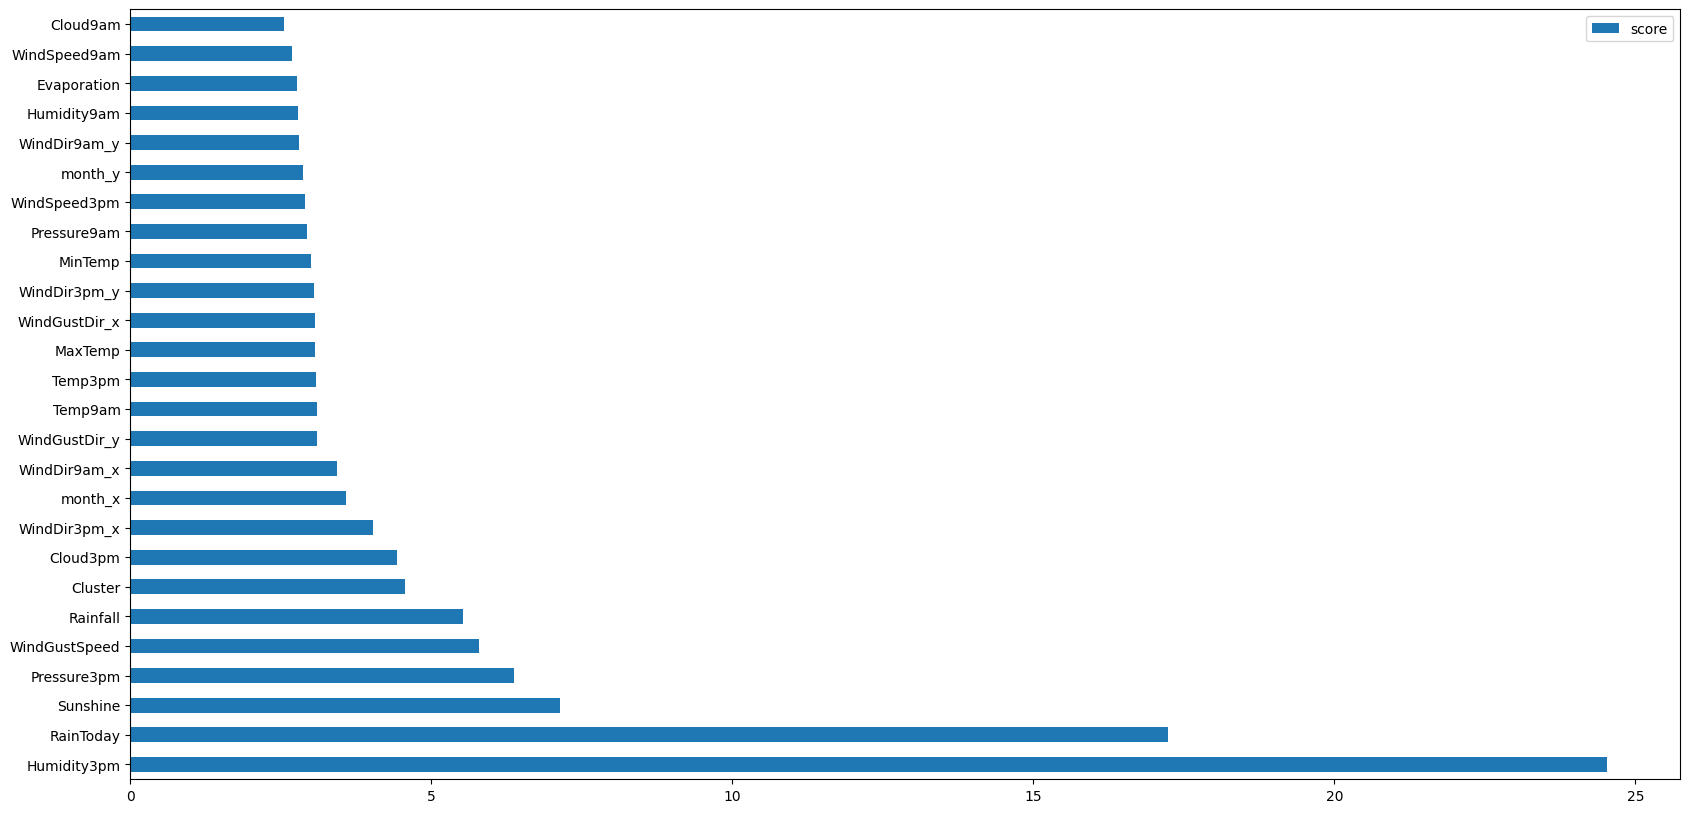

In [15]:
feature_important = xgb_ro.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_exp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_exp.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

<Axes: >

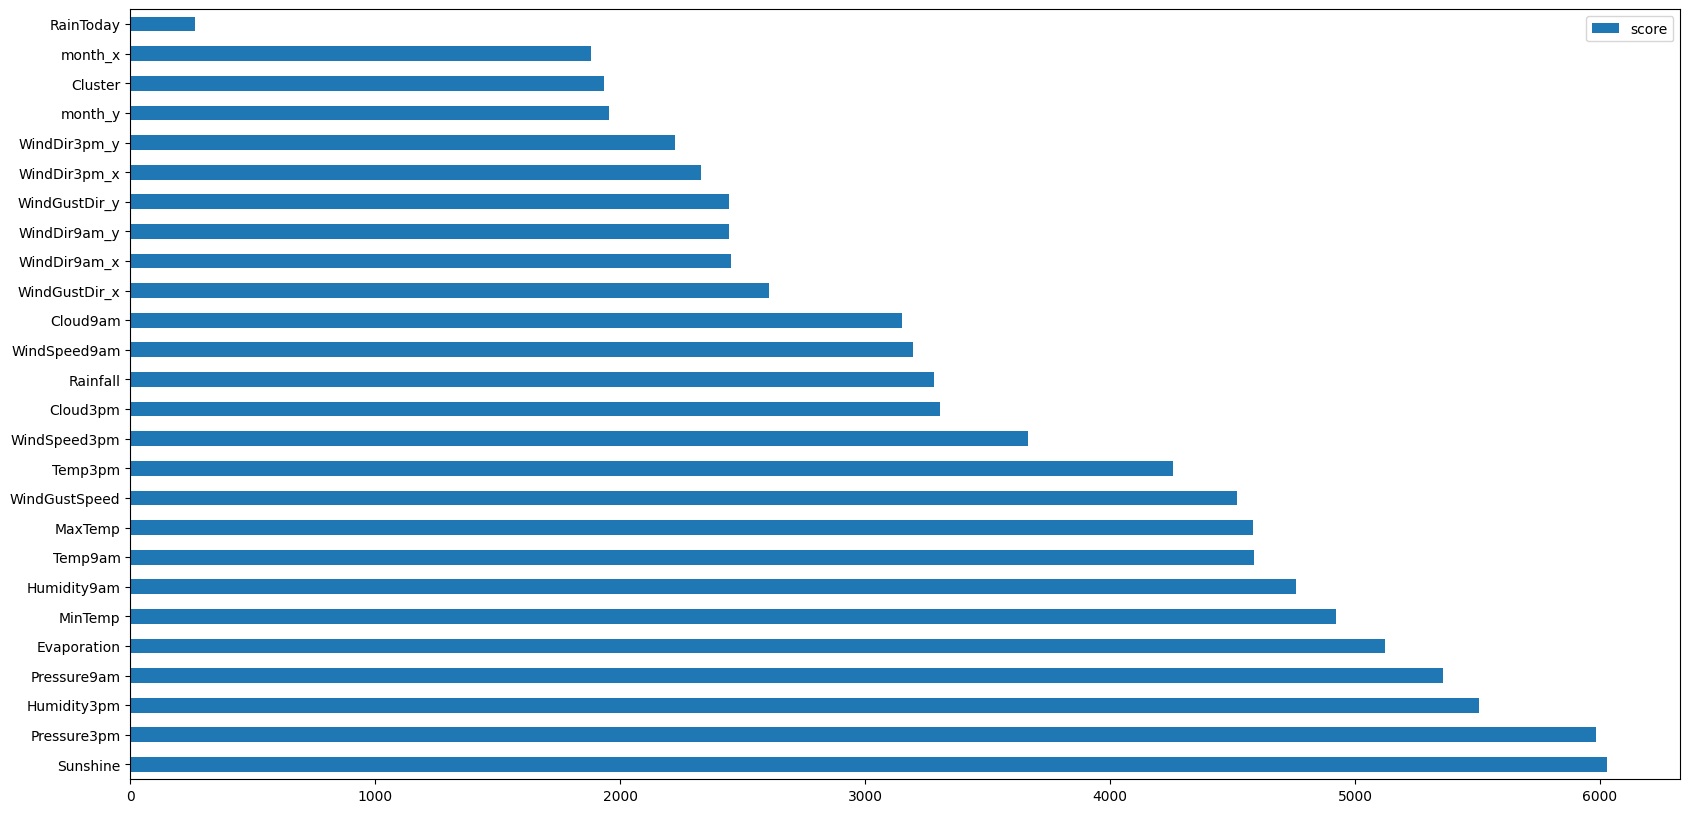

In [16]:
feature_important = xgb_ro.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

<Axes: >

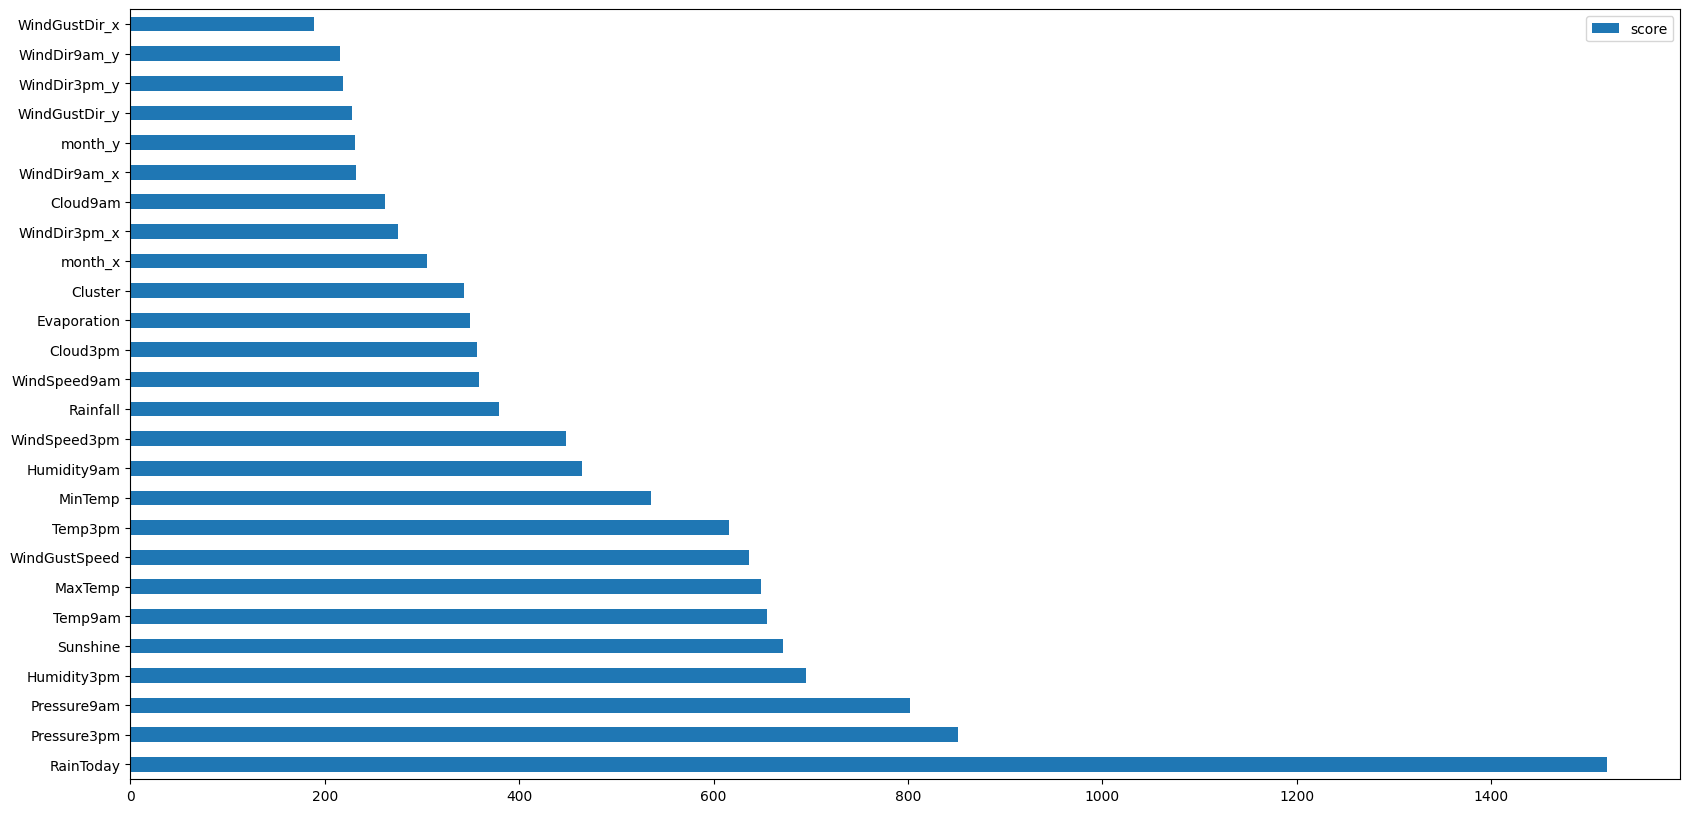

In [17]:
feature_important = xgb_ro.get_score(importance_type='cover')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

### Explaining the model with SHAP

In [15]:
explainer = shap.Explainer(xgb_ro)

In [16]:
#Training the shap model (may take up to 45 minutes)
shap_values = explainer(X_train_ro)

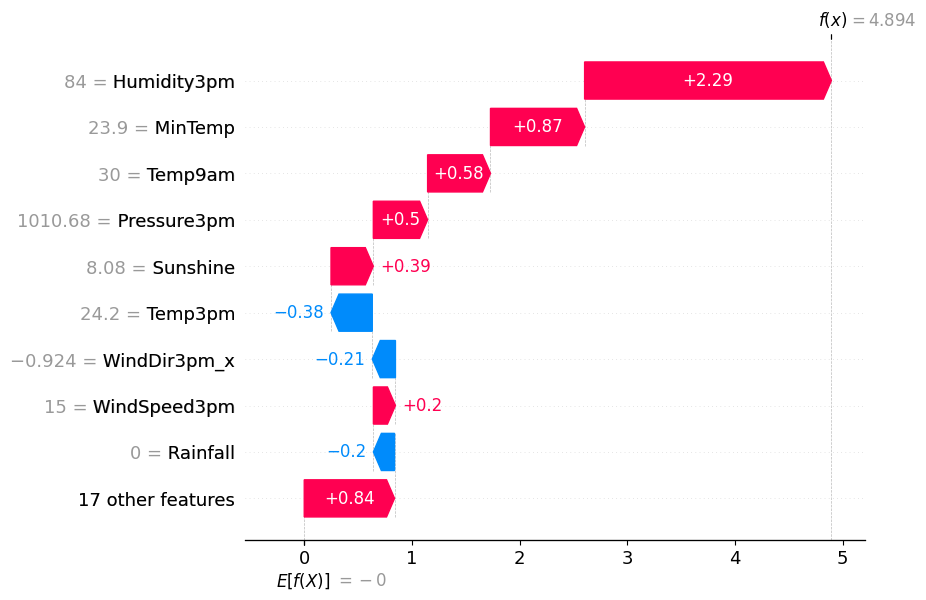

In [17]:
shap.plots.waterfall(shap_values[0])

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[4,:], X_train_ro.iloc[4,:], link="logit") #Setting link="logit" reparametrizes the shap values so that they can be interpreted as propabilities

In [19]:
#We take 1000 random samples to see general trends in global explanations
shap_sample = shap_values.sample(1000, random_state=10) 

In [20]:
shap.force_plot(explainer.expected_value, shap_sample.values, X_train_ro)

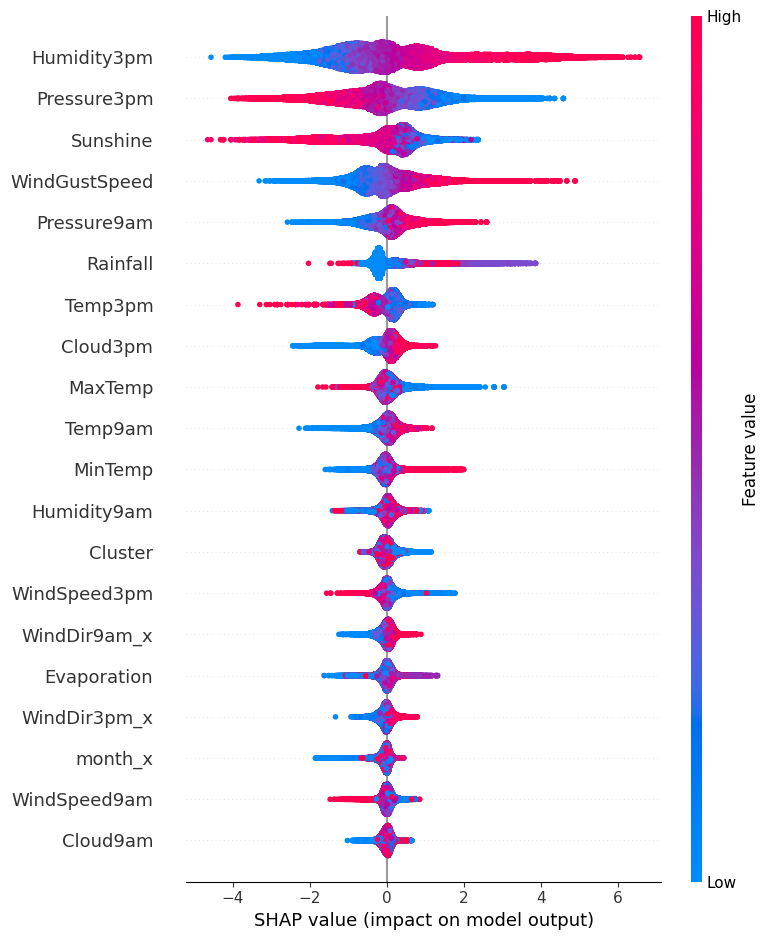

In [21]:
shap.summary_plot(shap_values)

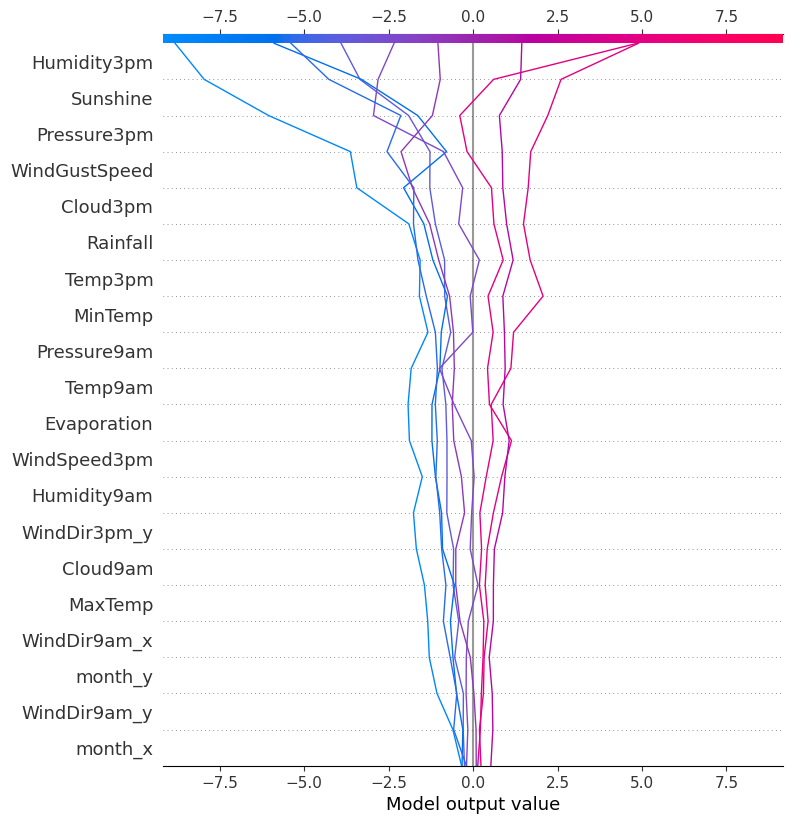

In [22]:
shap.decision_plot(explainer.expected_value, shap_values.values[0:9], X_train_ro)

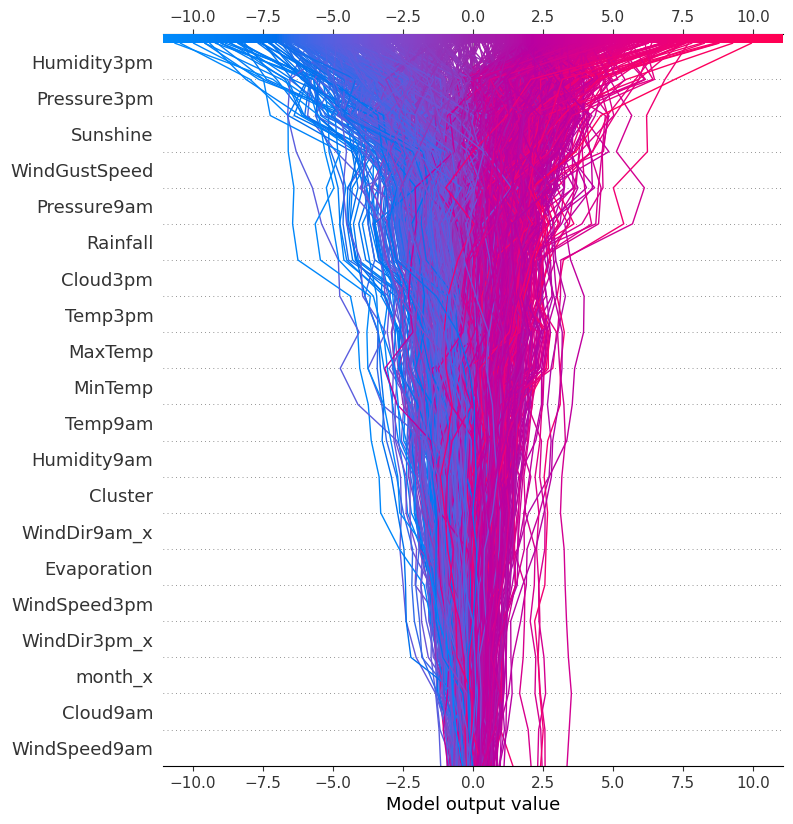

In [23]:
shap.decision_plot(explainer.expected_value, shap_sample.values, X_train_ro)

## Trying training of the model on reduced data

### Using only the most important variables

In [147]:
data_red = df.drop(['Temp3pm', 'Temp9am', 'MinTemp', 'MaxTemp', 'WindGustDir_y','WindGustDir_x','WindDir9am_y','WindDir3pm_y','WindDir9am_x','WindDir3pm_x', 'RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'Location', 'Cloud9am', 'Humidity9am', 'WindSpeed9am', 'Pressure9am', 'Evaporation'], axis = 1)

X_red, X_valid_red, y, y_valid = train_test_split(data_red, target, test_size=0.1)
X_train_red, X_test_red, y_train, y_test = train_test_split(X_red, y, test_size=0.2)

train_red = xgb.DMatrix(data=X_train_red, label=y_train)
test_red = xgb.DMatrix(data=X_test_red, label=y_test)
valid_red = xgb.DMatrix(data=X_valid_red, label=y_valid)

params = {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'binary:logistic'}
xgb_red = xgb.train(params=params, dtrain=train_red, num_boost_round=1000, evals=[(train_red, 'train'), (test_red, 'eval')])

[0]	train-logloss:0.50233	eval-logloss:0.50674
[1]	train-logloss:0.47821	eval-logloss:0.48321
[2]	train-logloss:0.45877	eval-logloss:0.46436
[3]	train-logloss:0.44265	eval-logloss:0.44881
[4]	train-logloss:0.42883	eval-logloss:0.43547
[5]	train-logloss:0.41738	eval-logloss:0.42461
[6]	train-logloss:0.40705	eval-logloss:0.41477
[7]	train-logloss:0.39831	eval-logloss:0.40646
[8]	train-logloss:0.39074	eval-logloss:0.39921
[9]	train-logloss:0.38414	eval-logloss:0.39302
[10]	train-logloss:0.37837	eval-logloss:0.38753
[11]	train-logloss:0.37331	eval-logloss:0.38284
[12]	train-logloss:0.36884	eval-logloss:0.37875
[13]	train-logloss:0.36488	eval-logloss:0.37511
[14]	train-logloss:0.36137	eval-logloss:0.37203
[15]	train-logloss:0.35821	eval-logloss:0.36928
[16]	train-logloss:0.35540	eval-logloss:0.36687
[17]	train-logloss:0.35280	eval-logloss:0.36459
[18]	train-logloss:0.35056	eval-logloss:0.36264
[19]	train-logloss:0.34846	eval-logloss:0.36080
[20]	train-logloss:0.34662	eval-logloss:0.35924
[2

In [135]:
preds = xgb_red.predict(test_red)

xgbpreds = pd.Series(np.where(preds > 0.35, 1, 0))

print(classification_report(pd.Series(y_test).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     19857
         1.0       0.66      0.70      0.68      5738

    accuracy                           0.85     25595
   macro avg       0.79      0.80      0.79     25595
weighted avg       0.86      0.85      0.85     25595



Predictions,0.0,1.0
Observations,,
0,17804,1716
1,2053,4022


### Training on the different clusters

In [34]:
print(data['Cluster'].value_counts())

Cluster
0    45148
2    27983
1    24187
4    23582
3    21293
Name: count, dtype: int64


In [72]:
#Cluster 4
df_4 = df[df['Cluster'] == 3]

target_4 = df_4['RainTomorrow']
data_4 = df_4.drop(['RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'month', 'Location', 'Cluster'], axis = 1)

X_4, X_valid_4, y_4, y_valid_4 = train_test_split(data_4, target_4, test_size=0.1)

#random oversampling
rOs_4 = RandomOverSampler()
X_ro_4, y_ro_4 = rOs_4.fit_resample(X_4, y_4)
print('Random Oversampling amount:', dict(pd.Series(y_ro_4).value_counts()))
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_ro_4, y_ro_4, test_size=0.2)

train_4 = xgb.DMatrix(data=X_train_4, label=y_train_4)
test_4 = xgb.DMatrix(data=X_test_4, label=y_test_4)
valid_4 = xgb.DMatrix(data=X_valid_4, label=y_valid_4)

params = {'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'objective': 'binary:logistic'}
xgb_4 = xgb.train(params=params, dtrain=train_4, num_boost_round=300, evals=[(train_4, 'train'), (test_4, 'eval')])

Random Oversampling amount: {1.0: 15224, 0.0: 15224}
[0]	train-logloss:0.60128	eval-logloss:0.60878
[1]	train-logloss:0.53655	eval-logloss:0.54984
[2]	train-logloss:0.48694	eval-logloss:0.50663
[3]	train-logloss:0.44886	eval-logloss:0.47221
[4]	train-logloss:0.41959	eval-logloss:0.44664
[5]	train-logloss:0.39604	eval-logloss:0.42707
[6]	train-logloss:0.37697	eval-logloss:0.41105
[7]	train-logloss:0.36071	eval-logloss:0.39706
[8]	train-logloss:0.34678	eval-logloss:0.38614
[9]	train-logloss:0.33492	eval-logloss:0.37604
[10]	train-logloss:0.32430	eval-logloss:0.36819
[11]	train-logloss:0.31668	eval-logloss:0.36168
[12]	train-logloss:0.30758	eval-logloss:0.35427
[13]	train-logloss:0.30069	eval-logloss:0.34873
[14]	train-logloss:0.29604	eval-logloss:0.34513
[15]	train-logloss:0.28925	eval-logloss:0.34029
[16]	train-logloss:0.28567	eval-logloss:0.33804
[17]	train-logloss:0.28011	eval-logloss:0.33345
[18]	train-logloss:0.27465	eval-logloss:0.33003
[19]	train-logloss:0.27284	eval-logloss:0.328

In [73]:
preds_4 = xgb_4.predict(valid_4)

xgbpreds = pd.Series(np.where(preds_4 > 0.5, 1, 0))

print(classification_report(pd.Series(y_valid_4).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_valid_4).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1711
         1.0       0.62      0.68      0.65       419

    accuracy                           0.85      2130
   macro avg       0.77      0.79      0.78      2130
weighted avg       0.86      0.85      0.86      2130



Predictions,0.0,1.0
Observations,,
0,1535,135
1,176,284


In [38]:
#Cluster 3
df_3 = df[df['Cluster'] == 3]

target_3 = df_3['RainTomorrow']
data_3 = df_3.drop(['RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'Location', 'Cluster'], axis = 1)

X_3, X_valid_3, y, y_valid = train_test_split(data_3, target_3, test_size=0.1)
X_train_3, X_test_3, y_train, y_test = train_test_split(X_3, y, test_size=0.2)

train_3 = xgb.DMatrix(data=X_train_3, label=y_train)
test_3 = xgb.DMatrix(data=X_test_3, label=y_test)
valid_3 = xgb.DMatrix(data=X_valid_3, label=y_valid)

params = {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'objective': 'binary:logistic'}
xgb_3 = xgb.train(params=params, dtrain=train_3, num_boost_round=300, evals=[(train_3, 'train'), (test_3, 'eval')])

[0]	train-logloss:0.48981	eval-logloss:0.49659
[1]	train-logloss:0.47287	eval-logloss:0.48156
[2]	train-logloss:0.45761	eval-logloss:0.46828
[3]	train-logloss:0.44386	eval-logloss:0.45619
[4]	train-logloss:0.43139	eval-logloss:0.44535
[5]	train-logloss:0.41998	eval-logloss:0.43545
[6]	train-logloss:0.40938	eval-logloss:0.42659
[7]	train-logloss:0.39962	eval-logloss:0.41837
[8]	train-logloss:0.39056	eval-logloss:0.41115
[9]	train-logloss:0.38224	eval-logloss:0.40390
[10]	train-logloss:0.37441	eval-logloss:0.39763
[11]	train-logloss:0.36699	eval-logloss:0.39134
[12]	train-logloss:0.35979	eval-logloss:0.38554
[13]	train-logloss:0.35332	eval-logloss:0.38006
[14]	train-logloss:0.34720	eval-logloss:0.37522
[15]	train-logloss:0.34157	eval-logloss:0.37074
[16]	train-logloss:0.33619	eval-logloss:0.36678
[17]	train-logloss:0.33079	eval-logloss:0.36280
[18]	train-logloss:0.32569	eval-logloss:0.35904
[19]	train-logloss:0.32107	eval-logloss:0.35548
[20]	train-logloss:0.31676	eval-logloss:0.35212
[2

In [39]:
preds_3 = xgb_3.predict(test_3)

xgbpreds = pd.Series(np.where(preds_3 > 0.35, 1, 0))

print(classification_report(pd.Series(y_test).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      3035
         1.0       0.67      0.69      0.68       798

    accuracy                           0.87      3833
   macro avg       0.79      0.80      0.80      3833
weighted avg       0.87      0.87      0.87      3833



Predictions,0.0,1.0
Observations,,
0,2764,245
1,271,553


In [45]:
#Cluster 2
df_2 = df[df['Cluster'] == 2]

target_2 = df_2['RainTomorrow']
data_2 = df_2.drop(['RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'Location', 'Cluster'], axis = 1)

X_2, X_valid_2, y, y_valid = train_test_split(data_2, target_2, test_size=0.1)
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size=0.2)

train_2 = xgb.DMatrix(data=X_train_2, label=y_train)
test_2 = xgb.DMatrix(data=X_test_2, label=y_test)
valid_2 = xgb.DMatrix(data=X_valid_2, label=y_valid)

params = {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'objective': 'binary:logistic'}
xgb_2 = xgb.train(params=params, dtrain=train_2, num_boost_round=500, evals=[(train_2, 'train'), (test_2, 'eval')])

[0]	train-logloss:0.51792	eval-logloss:0.51764
[1]	train-logloss:0.50209	eval-logloss:0.50391
[2]	train-logloss:0.48767	eval-logloss:0.49156
[3]	train-logloss:0.47486	eval-logloss:0.48055
[4]	train-logloss:0.46291	eval-logloss:0.47066
[5]	train-logloss:0.45191	eval-logloss:0.46158
[6]	train-logloss:0.44186	eval-logloss:0.45317
[7]	train-logloss:0.43253	eval-logloss:0.44545
[8]	train-logloss:0.42403	eval-logloss:0.43842
[9]	train-logloss:0.41598	eval-logloss:0.43191
[10]	train-logloss:0.40840	eval-logloss:0.42594
[11]	train-logloss:0.40156	eval-logloss:0.42051
[12]	train-logloss:0.39490	eval-logloss:0.41520
[13]	train-logloss:0.38861	eval-logloss:0.41033
[14]	train-logloss:0.38291	eval-logloss:0.40606
[15]	train-logloss:0.37735	eval-logloss:0.40212
[16]	train-logloss:0.37239	eval-logloss:0.39822
[17]	train-logloss:0.36741	eval-logloss:0.39457
[18]	train-logloss:0.36261	eval-logloss:0.39112
[19]	train-logloss:0.35815	eval-logloss:0.38786
[20]	train-logloss:0.35397	eval-logloss:0.38452
[2

In [22]:
preds_2 = xgb_2.predict(test_2)

xgbpreds = pd.Series(np.where(preds_2 > 0.35, 1, 0))

print(classification_report(pd.Series(y_test).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      3879
         1.0       0.66      0.72      0.69      1158

    accuracy                           0.85      5037
   macro avg       0.79      0.81      0.80      5037
weighted avg       0.86      0.85      0.85      5037



Predictions,0.0,1.0
Observations,,
0,3452,320
1,427,838


In [39]:
#Cluster 1
df_1 = df[df['Cluster'] == 1]

target_1 = df_1['RainTomorrow']
data_1 = df_1.drop(['RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'Location', 'Cluster'], axis = 1)

X_1, X_valid_1, y, y_valid = train_test_split(data_1, target_1, test_size=0.1)
X_train_1, X_test_1, y_train, y_test = train_test_split(X_1, y, test_size=0.2)

train_1 = xgb.DMatrix(data=X_train_1, label=y_train)
test_1 = xgb.DMatrix(data=X_test_1, label=y_test)
valid_1 = xgb.DMatrix(data=X_valid_1, label=y_valid)

params = {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'objective': 'binary:logistic'}
xgb_1 = xgb.train(params=params, dtrain=train_1, num_boost_round=500, evals=[(train_1, 'train'), (test_1, 'eval')])

[0]	train-logloss:0.50123	eval-logloss:0.49763
[1]	train-logloss:0.47737	eval-logloss:0.47498
[2]	train-logloss:0.45706	eval-logloss:0.45616
[3]	train-logloss:0.44082	eval-logloss:0.44068
[4]	train-logloss:0.42675	eval-logloss:0.42750
[5]	train-logloss:0.41437	eval-logloss:0.41617
[6]	train-logloss:0.40385	eval-logloss:0.40632
[7]	train-logloss:0.39443	eval-logloss:0.39743
[8]	train-logloss:0.38622	eval-logloss:0.39053
[9]	train-logloss:0.37911	eval-logloss:0.38390
[10]	train-logloss:0.37240	eval-logloss:0.37800
[11]	train-logloss:0.36683	eval-logloss:0.37298
[12]	train-logloss:0.36146	eval-logloss:0.36796
[13]	train-logloss:0.35671	eval-logloss:0.36424
[14]	train-logloss:0.35262	eval-logloss:0.36055
[15]	train-logloss:0.34879	eval-logloss:0.35728
[16]	train-logloss:0.34539	eval-logloss:0.35443
[17]	train-logloss:0.34204	eval-logloss:0.35178
[18]	train-logloss:0.33897	eval-logloss:0.34943
[19]	train-logloss:0.33597	eval-logloss:0.34744
[20]	train-logloss:0.33339	eval-logloss:0.34537
[2

In [40]:
preds_1 = xgb_1.predict(test_1)

xgbpreds = pd.Series(np.where(preds_1 > 0.35, 1, 0))

print(classification_report(pd.Series(y_test).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      3401
         1.0       0.69      0.68      0.68       953

    accuracy                           0.86      4354
   macro avg       0.80      0.80      0.80      4354
weighted avg       0.86      0.86      0.86      4354



Predictions,0.0,1.0
Observations,,
0,3103,303
1,298,650


In [57]:
#Cluster 0
df_0 = df[df['Cluster'] == 1]

target_0 = df_0['RainTomorrow']
data_0 = df_0.drop(['RainTomorrow', 'Rainfall_yesterday', 'Rainfall_tomorrow', 'Date', 'Location', 'Cluster'], axis = 1)

X_0, X_valid_0, y, y_valid = train_test_split(data_0, target_0, test_size=0.1)
X_train_0, X_test_0, y_train, y_test = train_test_split(X_0, y, test_size=0.2)

train_0 = xgb.DMatrix(data=X_train_0, label=y_train)
test_0 = xgb.DMatrix(data=X_test_0, label=y_test)
valid_0 = xgb.DMatrix(data=X_valid_0, label=y_valid)

params = {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 4, 'objective': 'binary:logistic'}
xgb_0 = xgb.train(params=params, dtrain=train_0, num_boost_round=1000, evals=[(train_0, 'train'), (test_0, 'eval')])

[0]	train-logloss:0.53192	eval-logloss:0.51861
[1]	train-logloss:0.52896	eval-logloss:0.51579
[2]	train-logloss:0.52606	eval-logloss:0.51304
[3]	train-logloss:0.52325	eval-logloss:0.51035
[4]	train-logloss:0.52051	eval-logloss:0.50775
[5]	train-logloss:0.51784	eval-logloss:0.50520
[6]	train-logloss:0.51524	eval-logloss:0.50273
[7]	train-logloss:0.51271	eval-logloss:0.50031
[8]	train-logloss:0.51023	eval-logloss:0.49793
[9]	train-logloss:0.50781	eval-logloss:0.49560
[10]	train-logloss:0.50545	eval-logloss:0.49337
[11]	train-logloss:0.50314	eval-logloss:0.49116
[12]	train-logloss:0.50089	eval-logloss:0.48899
[13]	train-logloss:0.49868	eval-logloss:0.48687
[14]	train-logloss:0.49653	eval-logloss:0.48484
[15]	train-logloss:0.49442	eval-logloss:0.48280
[16]	train-logloss:0.49236	eval-logloss:0.48087
[17]	train-logloss:0.49034	eval-logloss:0.47892
[18]	train-logloss:0.48837	eval-logloss:0.47703
[19]	train-logloss:0.48643	eval-logloss:0.47516
[20]	train-logloss:0.48453	eval-logloss:0.47334
[2

In [58]:
preds_0 = xgb_0.predict(test_0)

xgbpreds = pd.Series(np.where(preds_0 > 0.35, 1, 0))

print(classification_report(pd.Series(y_test).reset_index(drop=True), xgbpreds))
pd.crosstab(xgbpreds, pd.Series(y_test).reset_index(drop=True), colnames = ['Predictions'], rownames = ['Observations'])

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      3427
         1.0       0.66      0.66      0.66       927

    accuracy                           0.86      4354
   macro avg       0.79      0.78      0.79      4354
weighted avg       0.86      0.86      0.86      4354



Predictions,0.0,1.0
Observations,,
0,3116,315
1,311,612
